In this notebook, we are gonna train a vision model to tell whether a license plate is BC plate or not.

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')
     

In [2]:
urls = search_images('Alberta license plate', max_images=1)
urls[0]
     

'http://shopworldlicenseplates.com/store/image/cache/catalog/Alberta-16-2250x1200.jpg'

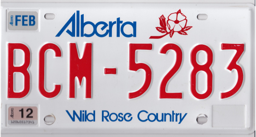

In [3]:
from fastdownload import download_url
dest = 'ab_plate.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

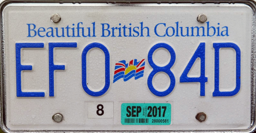

In [4]:
download_url(search_images('British Columbia license plate', max_images=1)[0], 'bc_plate.jpg', show_progress=False)
Image.open('bc_plate.jpg').to_thumb(256,256)

In [6]:

searches = 'Alberta license plate','British Columbia license plate'
path = Path('ab_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

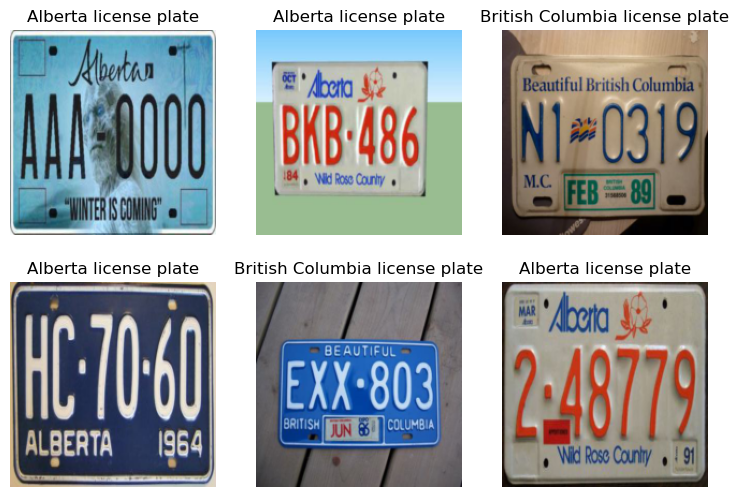

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/leilingtao/anaconda/envs/nobleprog_training/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/leilingtao/anaconda/envs/nobleprog_training/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/leilingtao/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.112811,1.000087,0.382353,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.445615,0.477751,0.264706,00:33
1,0.363522,0.382744,0.191176,00:33
2,0.296633,0.317879,0.176471,00:31


In [13]:
is_ab,_,probs = learn.predict(PILImage.create('ab_plate.jpg'))
print(f"This is a {is_ab}.")
print(f"Probability it's a AB license plate: {probs[0]:.4f}")

This is a Alberta license plate.
Probability it's a AB license plate: 0.9995


In [15]:
is_bc,_,probs = learn.predict(PILImage.create('bc_plate.jpg'))
print(f"This is a {is_bc}.")
print(f"Probability it's a AB license plate: {probs[0]:.4f}")

This is a British Columbia license plate.
Probability it's a AB license plate: 0.0003
